# Laboratorium 9 - Problem dekonfliktacji statków powietrznych, cz.2
## Jędrzej Warczyński
### 07.05.2023 

## Sformułowanie problemu

1. zmienne decyzyjne
   - $x_{ij}$ - zmienna określająca czy i-ty statek wykonuje j-ty manewr 
2. Stałe
   - $c_{ijkl}$ - występowanie knfliktu statku i-tego wykonującego manewr j-ty ze stakiem k-tym wykonującym manewr l-ty

1. Zminimalizować 
   - $\sum_{i=1}^n\sum_{j=1}^m(j \cdot x_{ij})$
   - im wyższy numer manewru tym większy koszt
   
2. Ograniczenia
   
   1. 
      - $
        \forall_i\sum_{j=1}^{7}x_{ij} = 1  
        $
      - samolot może wykonać tylko jeden manewr   
   2. 
      - $
        \forall_i\forall_j\forall_k\forall_k(x_{ij} \cdot c_{ijkl} + x_{kl} \cdot c_{ijkl}) \leq 1 \
        $
      - brak konfliktów 
   3.
      - $x_{ij} \in \{0,1\}$
      - zmienn decyzyjne są binarne


## Wczytanie danych z pliku do macierzy kolizji

In [13]:
MANEUVER = 7
def read_matrix(filename):
    # Wyciągnięcie wielkości instancji z nazwy pliku
    num_str = filename.split("_")[2].split(".")[0]
    num = int(num_str)
    
    # Otwarcie pliku i odczytanie zawartości
    with open("data/"+filename, 'r') as f:
        content = f.read()

    # Konwersja zawartości na listę int'ów
    colision_matrix = []
    idx = 0
    numbers = [int(x) for x in content.split()]

    # załadowanie dancyh do macierzy kolizji 
    for manewr in range(MANEUVER):
        colision_matrix.append([])
        for plane in range(num):
            colision_matrix[manewr].append([])
            for manewr2 in range(MANEUVER):
                colision_matrix[manewr][plane].append([])
                for _ in range(num):
                    colision_matrix[manewr][plane][manewr2].append(numbers[idx])
                    idx += 1

    return colision_matrix, num

## Deklaracja nazw instancji problemu

In [14]:
filenames = ["CM_RCP_10.txt", "CM_RCP_20.txt", "CM_RCP_30.txt", "CM_RCP_40.txt"]

## Tworzenie modelu i rozwiązanie problemu na podstawie macirzy kolizji i ilości statków powietrznych

In [15]:
from docplex.mp.model import Model

def deconflict(cm, planes_num):
    # Tworzenie modelu
    model = Model(name='Binary variables model')

    # Zmienne decyzyjne
    x = {(i,j): model.binary_var(name='x_{0}_{1}'.format(i,j)) for i in range(0,planes_num) for j in range(0, MANEUVER)}

    # Ograniczenia
    # Pierwsze ograniczenie
    for i in range(0,planes_num):
        model.add_constraint(model.sum(x[(i,j)] for j in range(0,MANEUVER)) == 1)

    # Drugie ograniczenie
    for i in range(0, planes_num):
        for j in range(0, MANEUVER):
            for k in range(i+1, planes_num):
                for l in range(0, MANEUVER):
                    model.add_constraint(x[(i,j)]*cm[j][i][l][k] + x[(k,l)]*cm[j][i][l][k] <= 1)

    # Funkcja celu
    model.minimize(model.sum(j * x[(i,j)] for i in range(0,planes_num) for j in range(0, MANEUVER)))

    # Rozwiązanie problemu
    model.solve()

    return model, x

## Wyświeltnienie wartości zmiennych i czasu obliczeń

In [16]:
import pandas as pd

def show_table(model, x, planes_num, filename):
    data = []
    for i in range(planes_num):
        for j in range(MANEUVER):
            if (x[(i,j)].solution_value == 1.0):
                data.append([i+1, j+1])
    
    df = pd.DataFrame(data, columns=["Plane", "Maneuver"])
    df["Maneuver"] = df["Maneuver"].apply(str)
    
    return df

def showResults(model, x, planes_num):
    print('Status: ', model.solve_details.status)
    print('Czas obliczeń: ', model.solve_details.time, 's')
    if model.solve_details.status == 'integer optimal solution':
        print('Wartości zmiennych x:')
        for i in range(0,planes_num):
            for j in range(0, MANEUVER):
                if (x[(i,j)].solution_value == 1.0):
                    print('x_{0}_{1} = {2}'.format(i, j, x[(i,j)].solution_value))
    else:
        print('Nie udało się rozwiązać problemu.')

## Rozwiąznie instancji problemu i wyświetlenie wyników

In [17]:
from IPython.display import display_html 

times = [] 
dfs = []
for instance in filenames:
    cm, planes_num = read_matrix(instance)
    model, x = deconflict(cm, planes_num)
    times.append(model.solve_details.time)
    df= show_table(model, x, planes_num, instance)
    df1_styler = df.style.set_table_attributes("style='display:inline'").set_caption(instance)
    dfs.append(df1_styler)

space = "\xa0" * 10
display_html(dfs[3]._repr_html_() + space + dfs[2]._repr_html_() + space + dfs[1]._repr_html_() + space + dfs[0]._repr_html_(), raw=True)
    # display(style)

,Plane,Maneuver
0,1,1
1,2,1
2,3,3
3,4,3
4,5,3
5,6,1
6,7,3
7,8,3
8,9,3
9,10,1


## Porównanie czasu obliczeń

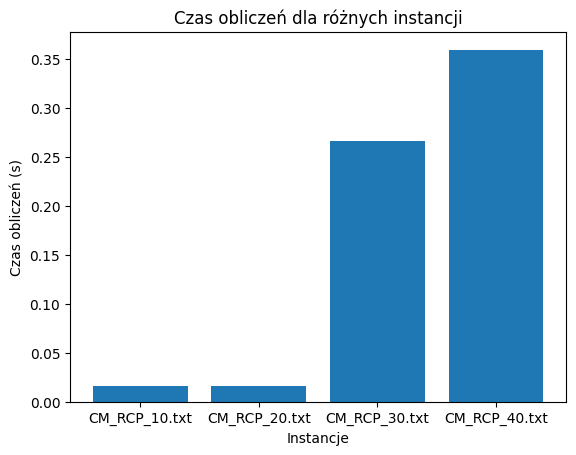

In [18]:
import matplotlib.pyplot as plt

plt.bar(filenames, times)
plt.xlabel('Instancje')
plt.ylabel('Czas obliczeń (s)')
plt.title('Czas obliczeń dla różnych instancji')
plt.show()